In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision import models
from torchvision.datasets import VOCSegmentation
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Load the VOC dataset
val_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def target_transform(mask):
    mask = mask.resize((256, 256), Image.NEAREST)
    mask = np.array(mask)
    mask = torch.from_numpy(mask).long()
    return mask

In [ ]:
# Load the VOC dataset
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=val_transform, target_transform=target_transform)

# Load the Deeplab model (pretrained on COCO)
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()


100%|██████████| 1999639040/1999639040 [02:14<00:00, 14837166.08it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 165MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
# Function to overlay segmentation mask on original image
def overlay_segmentation(image, mask):
    alpha = 0.6  # Transparency factor

    # Create color map for visualization
    colormap = np.array([
        [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
        [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
        [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
        [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
        [0, 64, 128], [128, 64, 128], [0, 192, 128], [128, 192, 128], [64, 64, 0],
        [192, 64, 0], [64, 192, 0], [192, 192, 0], [64, 64, 128], [192, 64, 128],
        [64, 192, 128], [192, 192, 128], [0, 0, 64], [128, 0, 64], [0, 128, 64],
        [128, 128, 64], [0, 0, 192], [128, 0, 192], [0, 128, 192], [128, 128, 192],
        [64, 0, 64], [192, 0, 64], [64, 128, 64], [192, 128, 64], [64, 0, 192],
        [192, 0, 192], [64, 128, 192], [192, 128, 192], [0, 64, 64], [128, 64, 64],
        [0, 192, 64], [128, 192, 64], [0, 64, 192], [128, 64, 192], [0, 192, 192],
        [128, 192, 192], [64, 64, 64], [192, 64, 64], [64, 192, 64], [192, 192, 64],
        [64, 64, 192], [192, 64, 192], [64, 192, 192], [192, 192, 192], [32, 0, 0],
        [160, 0, 0], [32, 128, 0], [160, 128, 0], [32, 0, 128], [160, 0, 128],
        [32, 128, 128], [160, 128, 128], [96, 0, 0], [224, 0, 0], [96, 128, 0],
        [224, 128, 0], [96, 0, 128], [224, 0, 128], [96, 128, 128], [224, 128, 128],
        [32, 64, 0], [160, 64, 0], [32, 192, 0], [160, 192, 0], [32, 64, 128],
        [160, 64, 128], [32, 192, 128], [160, 192, 128], [96, 64, 0], [224, 64, 0],
        [96, 192, 0], [224, 192, 0], [96, 64, 128], [224, 64, 128], [96, 192, 128],
        [224, 192, 128]
    ])


    # Apply the colormap to the mask
    color_mask = colormap[mask].astype(np.uint8)

    # Ensure both images have the same type
    image = image.astype(np.uint8)

    # Overlay the mask on the original image
    overlay = cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
    return overlay


In [ ]:
def create_color_map():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[1] = [128, 0, 0]
    colormap[2] = [0, 128, 0]
    colormap[3] = [128, 128, 0]
    colormap[4] = [0, 0, 128]
    colormap[5] = [128, 0, 128]
    colormap[6] = [0, 128, 128]
    colormap[7] = [128, 128, 128]
    colormap[8] = [64, 0, 0]
    colormap[9] = [192, 0, 0]
    colormap[10] = [64, 128, 0]
    colormap[11] = [192, 128, 0]
    colormap[12] = [64, 0, 128]
    colormap[13] = [192, 0, 128]
    colormap[14] = [64, 128, 128]
    colormap[15] = [192, 128, 128]
    colormap[16] = [0, 64, 0]
    colormap[17] = [128, 64, 0]
    colormap[18] = [0, 192, 0]
    colormap[19] = [128, 192, 0]
    colormap[20] = [0, 64, 128]
    colormap[21] = [128, 64, 128]
    colormap[22] = [0, 192, 128]
    colormap[23] = [128, 192, 128]
    colormap[24] = [64, 64, 0]
    colormap[25] = [192, 64, 0]
    colormap[26] = [64, 192, 0]
    colormap[27] = [192, 192, 0]
    colormap[28] = [64, 64, 128]
    colormap[29] = [192, 64, 128]
    colormap[30] = [64, 192, 128]
    colormap[31] = [192, 192, 128]
    colormap[32] = [0, 0, 64]
    colormap[33] = [128, 0, 64]
    colormap[34] = [0, 128, 64]
    colormap[35] = [128, 128, 64]
    colormap[36] = [0, 0, 192]
    colormap[37] = [128, 0, 192]
    colormap[38] = [0, 128, 192]
    colormap[39] = [128, 128, 192]
    colormap[40] = [64, 0, 64]
    colormap[41] = [192, 0, 64]
    colormap[42] = [64, 128, 64]
    colormap[43] = [192, 128, 64]
    colormap[44] = [64, 0, 192]
    colormap[45] = [192, 0, 192]
    colormap[46] = [64, 128, 192]
    colormap[47] = [192, 128, 192]
    colormap[48] = [0, 64, 64]
    colormap[49] = [128, 64, 64]
    colormap[50] = [0, 192, 64]
    colormap[51] = [128, 192, 64]
    colormap[52] = [0, 64, 192]
    colormap[53] = [128, 64, 192]
    colormap[54] = [0, 192, 192]
    colormap[55] = [128, 192, 192]
    colormap[56] = [64, 64, 64]
    colormap[57] = [192, 64, 64]
    colormap[58] = [64, 192, 64]
    colormap[59] = [192, 192, 64]
    colormap[60] = [64, 64, 192]
    colormap[61] = [192, 64, 192]
    colormap[62] = [64, 192, 192]
    colormap[63] = [192, 192, 192]
    colormap[64] = [32, 0, 0]
    colormap[65] = [160, 0, 0]
    colormap[66] = [32, 128, 0]
    colormap[67] = [160, 128, 0]
    colormap[68] = [32, 0, 128]
    colormap[69] = [160, 0, 128]
    colormap[70] = [32, 128, 128]
    colormap[71] = [160, 128, 128]
    colormap[72] = [96, 0, 0]
    colormap[73] = [224, 0, 0]
    colormap[74] = [96, 128, 0]
    colormap[75] = [224, 128, 0]
    colormap[76] = [96, 0, 128]
    colormap[77] = [224, 0, 128]
    colormap[78] = [96, 128, 128]
    colormap[79] = [224, 128, 128]
    colormap[80] = [32, 64, 0]
    colormap[81] = [160, 64, 0]
    colormap[82] = [32, 192, 0]
    colormap[83] = [160, 192, 0]
    colormap[84] = [32, 64, 128]
    colormap[85] = [160, 64, 128]
    colormap[86] = [32, 192, 128]
    colormap[87] = [160, 192, 128]
    colormap[88] = [96, 64, 0]
    colormap[89] = [224, 64, 0]
    colormap[90] = [96, 192, 0]
    colormap[91] = [224, 192, 0]
    colormap[92] = [96, 64, 128]
    colormap[93] = [224, 64, 128]
    colormap[94] = [96, 192, 128]
    colormap[95] = [224, 192, 128]
    return colormap

In [ ]:
def decode_segmap(image, colormap):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 256):
        idx = image == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


In [ ]:
sample_idx = 1029  # Change this to any valid index to select a different image
original_img, test_mask = val_dataset[sample_idx]  # Get the original image and mask

# Convert the original image to a numpy array suitable for OpenCV
original_img_np = np.array(original_img.permute(1, 2, 0))  # Convert PIL Image to numpy array, ensuring proper channel order

# Remove the transform step as it's already a tensor
test_img = original_img.unsqueeze(0).to(device)  # Move to device

with torch.no_grad():
    output = model(test_img)
    # Extract the segmentation output from the dictionary
    output_tensor = output['out']
    output_predictions = output_tensor.argmax(1).squeeze(0).cpu().numpy()

# Convert the input image to a format suitable for OpenCV
input_image_cv = cv2.cvtColor(np.array(original_img_np), cv2.COLOR_RGB2BGR)  # Use the original image for display

# Overlay the segmentation mask on the original image


segmented_image = overlay_segmentation(input_image_cv, output_predictions)

# Decode the segmentation map
colormap = create_color_map()
seg_map = decode_segmap(output_predictions, colormap)

# Display the segmentation result using matplotlib
plt.figure(figsize=(20, 20))


<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

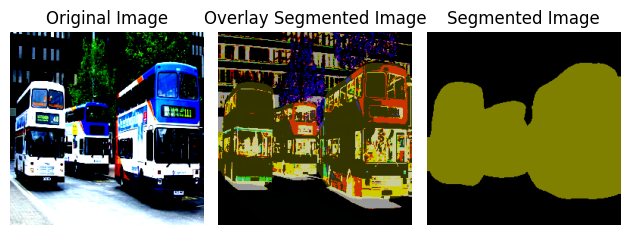

In [ ]:
# Display original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(input_image_cv, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display segmented image
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title('Overlay Segmented Image')
plt.axis('off')

# Display segmentation map
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(seg_map, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')

# Show plot
plt.tight_layout()
plt.show()